In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
df = pd.read_csv('/Users/jyots/Desktop/DS_Projects/airbnb_DataSets/Paris_dfm.csv',
                   encoding='utf8')

In [3]:
df.head(2)

,Unnamed: 0,bathrooms,bedrooms,bhk,dist_arprt,host_count,metrostn_count,minstay,neighborhood,overall_satisfaction,price,rest_count,review_count,reviews,room_type
0,0,1.0,1.0,1.0,0.19109,478,6,2.0,Amerique,5.0,93.0,1,3682,7,Entire home/apt
1,1,1.0,1.0,1.0,0.19109,478,6,2.0,Amerique,4.5,73.0,1,3682,31,Entire home/apt


In [4]:
df.drop('Unnamed: 0', inplace=True, axis=1)

In [5]:
#df['pproom'] = (df['price'] * df['minstay'])/df['bhk']

In [6]:
#df['pproom']

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet, LassoCV, Lasso

import patsy

In [69]:
df_corr = df[[x for x in df.columns if x not in ['Unnamed: 0','bhk']]].corr()

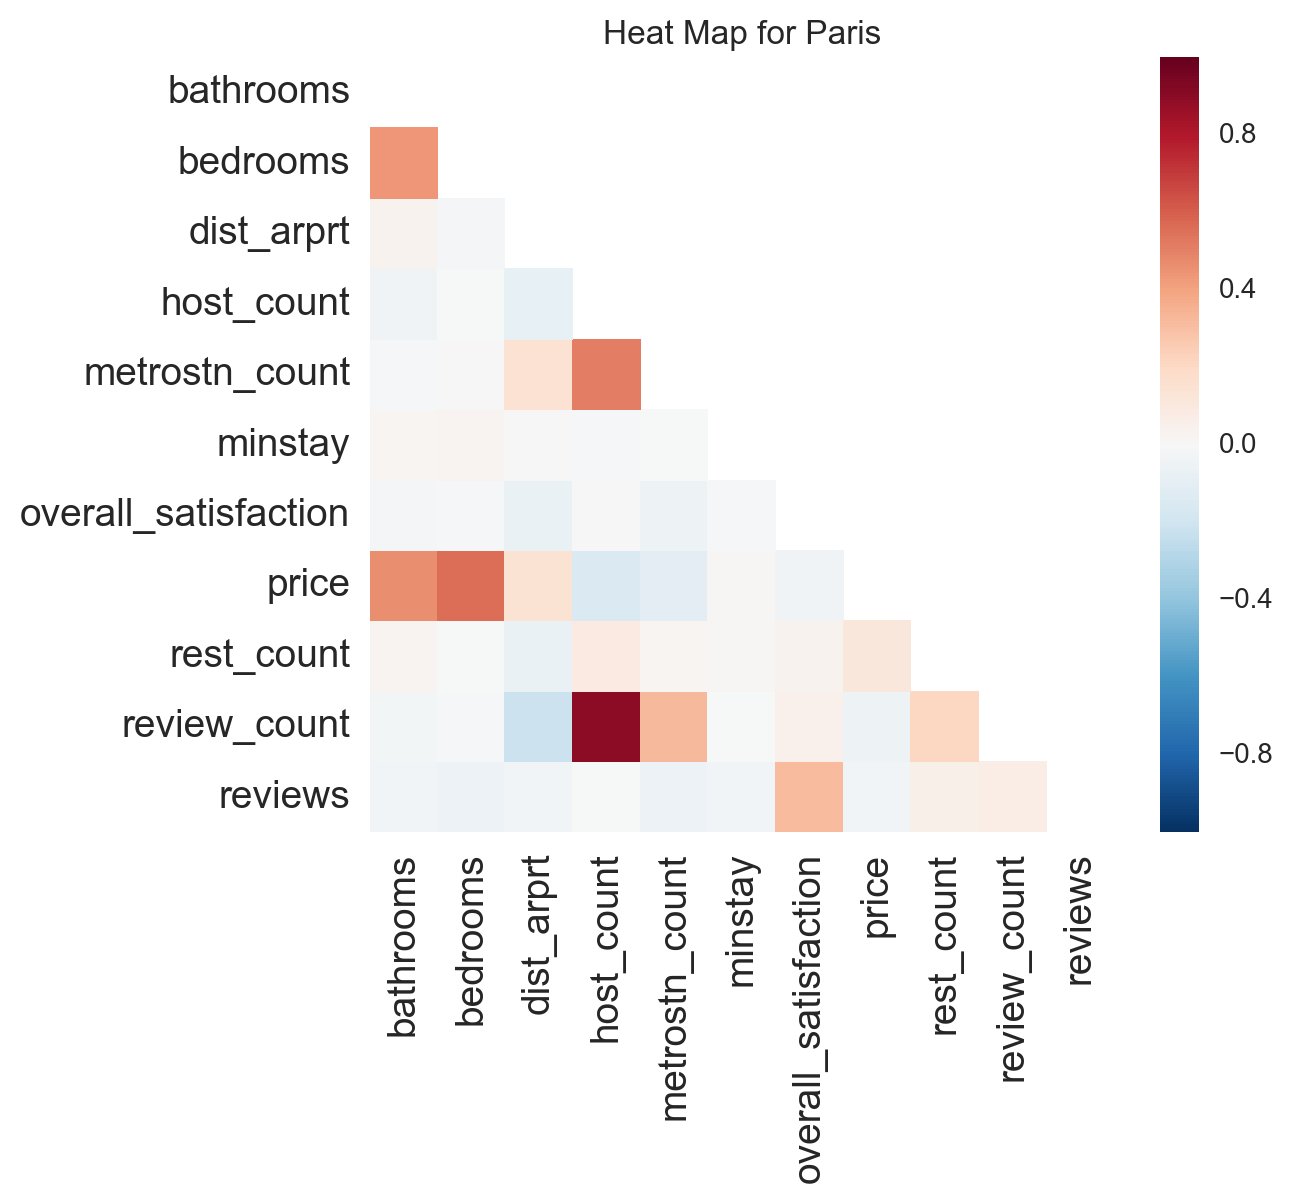

In [71]:
#for heatmap Set the default matplotlib figure size to 7x7:

plt.rcParams['figure.figsize']=(6,5)

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(df_corr, mask=mask)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)
ax.set_title('Heat Map for Paris')

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

In [8]:
df = df[df.price <= 1000]


In [9]:
df.shape

(41124, 14)

In [10]:
X = df[[x for x in df.columns if x not in ['bhk','price']]]
y = df.price.values
target = np.log(y)


In [11]:
formula = "target ~ "+' + '.join(X)+' -1'
formula

u'target ~ bathrooms + bedrooms + dist_arprt + host_count + metrostn_count + minstay + neighborhood + overall_satisfaction + rest_count + review_count + reviews + room_type -1'

In [12]:
y, X = patsy.dmatrices(formula, data=df, return_type='dataframe')
y = y.values.ravel()

In [13]:
y

array([ 4.53259949,  4.29045944,  3.91202301, ...,  4.61512052,
        6.10479323,  4.49980967])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [15]:
X_train.shape, X_test.shape

((28786, 92), (12338, 92))

In [16]:
X_test.head(2)

,neighborhood[Amerique],neighborhood[Archives],neighborhood[Arsenal],neighborhood[Arts-et-Metiers],neighborhood[Auteuil],neighborhood[Batignolles],neighborhood[Bel-Air],neighborhood[Belleville],neighborhood[Bercy],neighborhood[Bonne-Nouvelle],...,bathrooms,bedrooms,dist_arprt,host_count,metrostn_count,minstay,overall_satisfaction,rest_count,review_count,reviews
10986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,0.256753,424.0,5.0,2.0,5.0,2.0,3803.0,35.0
5088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.235433,765.0,2.0,2.0,4.5,5.0,13482.0,82.0


In [17]:
linmod = LinearRegression()

In [18]:
scores = cross_val_score(linmod, X_train, y_train, cv = 10)
print scores
print np.mean(scores)
print np.std(scores)

[ 0.59776849  0.57504734  0.5893603   0.57842874  0.58112632  0.59584617
  0.61264039  0.58869335  0.59237063  0.60244334]
0.591372506312
0.0108952640234


In [19]:
predictions = cross_val_predict(linmod, X_test, y_test, cv = 10) 
accuracy = metrics.r2_score(y_test, predictions)
print accuracy


0.586074888543


In [20]:
residuals = y_test - predictions
residuals

array([ 0.1317487 , -0.33630449, -0.02927806, ..., -0.08639043,
        0.1556329 ,  0.30188692])

In [21]:
np.mean(predictions)


4.5755710155816223

In [22]:
linmod.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [23]:
linmod.score(X_test, y_test)

0.58829552734983159

In [24]:
#linmod.coef_

In [25]:
print np.mean(y_train), np.mean(y_test)

4.57886365016 4.57549524128


In [26]:
# Regularization: Gridsearch an optimal ElasticNet regression

In [27]:
Xn = StandardScaler().fit_transform(X)

In [28]:
Xn_train, Xn_test, y_train, y_test = train_test_split(Xn, y, test_size = 0.3)

In [50]:
# enet_cv = ElasticNetCV(l1_ratio=np.linspace(0.01, 1., 50), n_alphas=300, cv=10, verbose=1)
# enet_cv.fit(Xn_train, y_train)


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=array([ 0.01   ,  0.0302 ,  0.05041,  0.07061,  0.09082,  0.11102,
        0.13122,  0.15143,  0.17163,  0.19184,  0.21204,  0.23224,
        0.25245,  0.27265,  0.29286,  0.31306,  0.33327,  0.35347,
        0.37367,  0.39388,  0.41408,  0.43429,  0.45449,  0.47469,
        0.4949 ,  0.515...3837,
        0.85857,  0.87878,  0.89898,  0.91918,  0.93939,  0.95959,
        0.9798 ,  1.     ]),
       max_iter=1000, n_alphas=300, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=1)

In [51]:
# print enet_cv.l1_ratio_
# print enet_cv.alpha_

1.0
0.000445770647484


In [72]:
import time

In [73]:
start_time = time.time()

alpha = 0.000445770647484
l1_ratio = 1.


enet = ElasticNet(alpha= alpha, l1_ratio=l1_ratio)

y_pred_enet = enet.fit(Xn_train, y_train).predict(Xn_test)
r2_score_enet = metrics.r2_score(y_test, y_pred_enet)
print(enet)
print("r^2 on test data : %f" % r2_score_enet)

print("--- %s seconds ---" % (time.time() - start_time))


ElasticNet(alpha=0.000445770647484, copy_X=True, fit_intercept=True,
      l1_ratio=1.0, max_iter=1000, normalize=False, positive=False,
      precompute=False, random_state=None, selection='cyclic', tol=0.0001,
      warm_start=False)
r^2 on test data : 0.587231
--- 1.777602911 seconds ---


In [53]:
lassocv = LassoCV(n_alphas=300, cv=10)

In [54]:
lassocv.fit(Xn_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=300, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [55]:
lassocv.alpha_

0.00044577064748389691

In [56]:
lasso = Lasso(alpha=lassocv.alpha_)
lasso_model = lasso.fit(Xn_train, y_train)
y_pred_lasso = lasso_model.predict(Xn_test)
r2_score_lasso = metrics.r2_score(y_test, y_pred_lasso)
print(lasso)
print("r^2 on test data : %f" % r2_score_lasso)


Lasso(alpha=0.00044577064748389691, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : 0.587231


In [58]:
residuals = np.exp(y_test) - np.exp(y_pred_enet)

In [59]:
neg_resd = [x for x in residuals.tolist() if x<0]
len(neg_resd)

6341

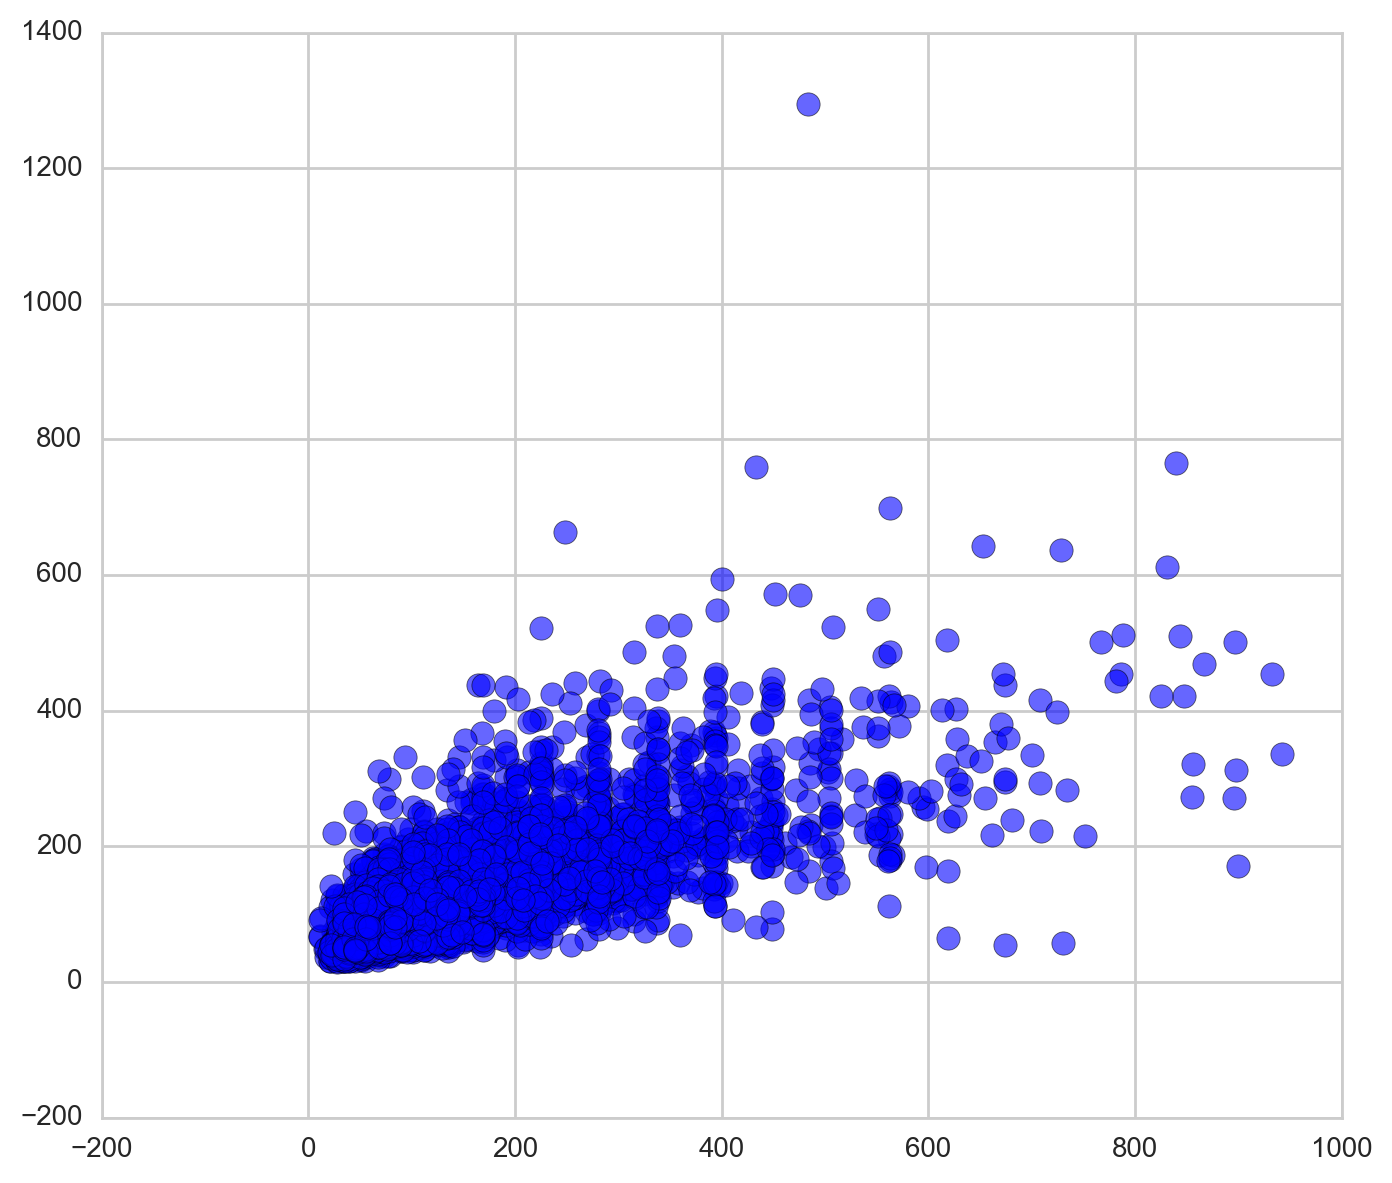

In [60]:
fig, ax = plt.subplots(figsize=(8,7))
ax.scatter(np.exp(y_test), np.exp(y_pred_enet), s=70, alpha=0.6)
plt.show()

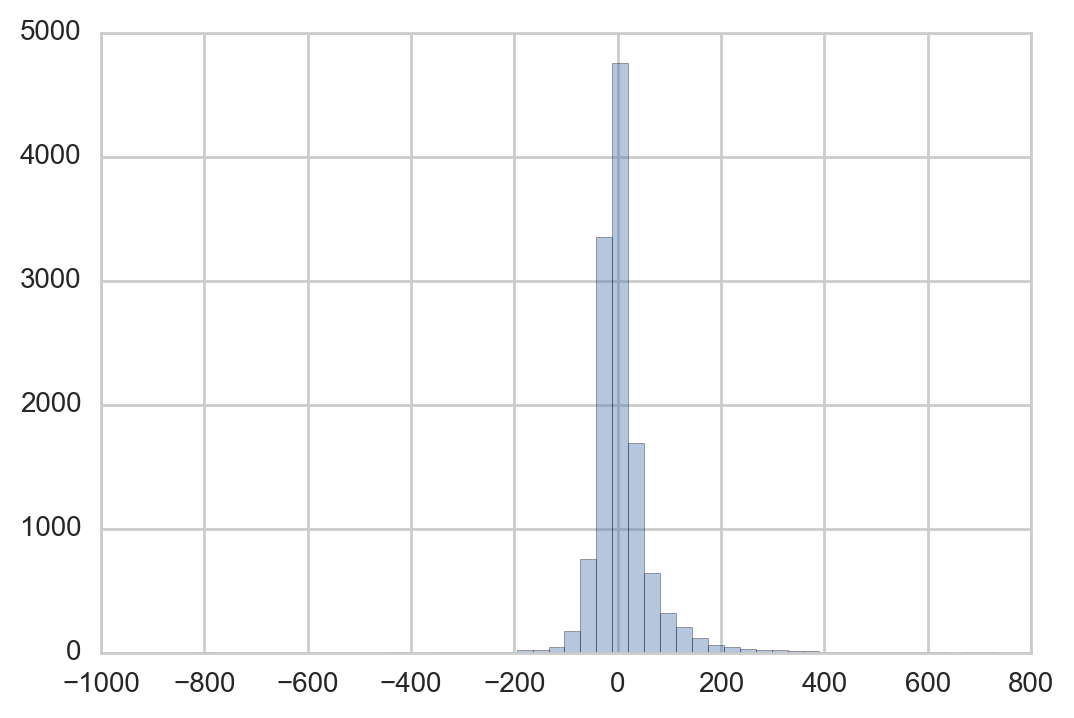

In [39]:
sns.distplot(residuals, bins=50, kde=False)

In [61]:
enet.fit(Xn_train, y_train)

enet_coef = pd.DataFrame({
        'variable':X_train.columns,
        'coef':enet.coef_,
        'abscoef':np.abs(enet.coef_)
    })

enet_coef.sort_values('abscoef', ascending=False, inplace=True)
enet_coef[enet_coef.coef != 0].head(25)


,abscoef,coef,variable
83,0.271363,0.271363,bedrooms
80,0.154700,-0.154700,room_type[T.Private room]
84,0.101156,0.101156,dist_arprt
85,0.097635,-0.097635,host_count
90,0.093825,0.093825,review_count
81,0.082979,-0.082979,room_type[T.Shared room]
89,0.064558,0.064558,rest_count
82,0.064307,0.064307,bathrooms
43,0.038775,0.038775,neighborhood[Notre-Dame]
86,0.034971,-0.034971,metrostn_count


In [62]:
enet_coef.sort_values('abscoef', ascending=False, inplace=True)

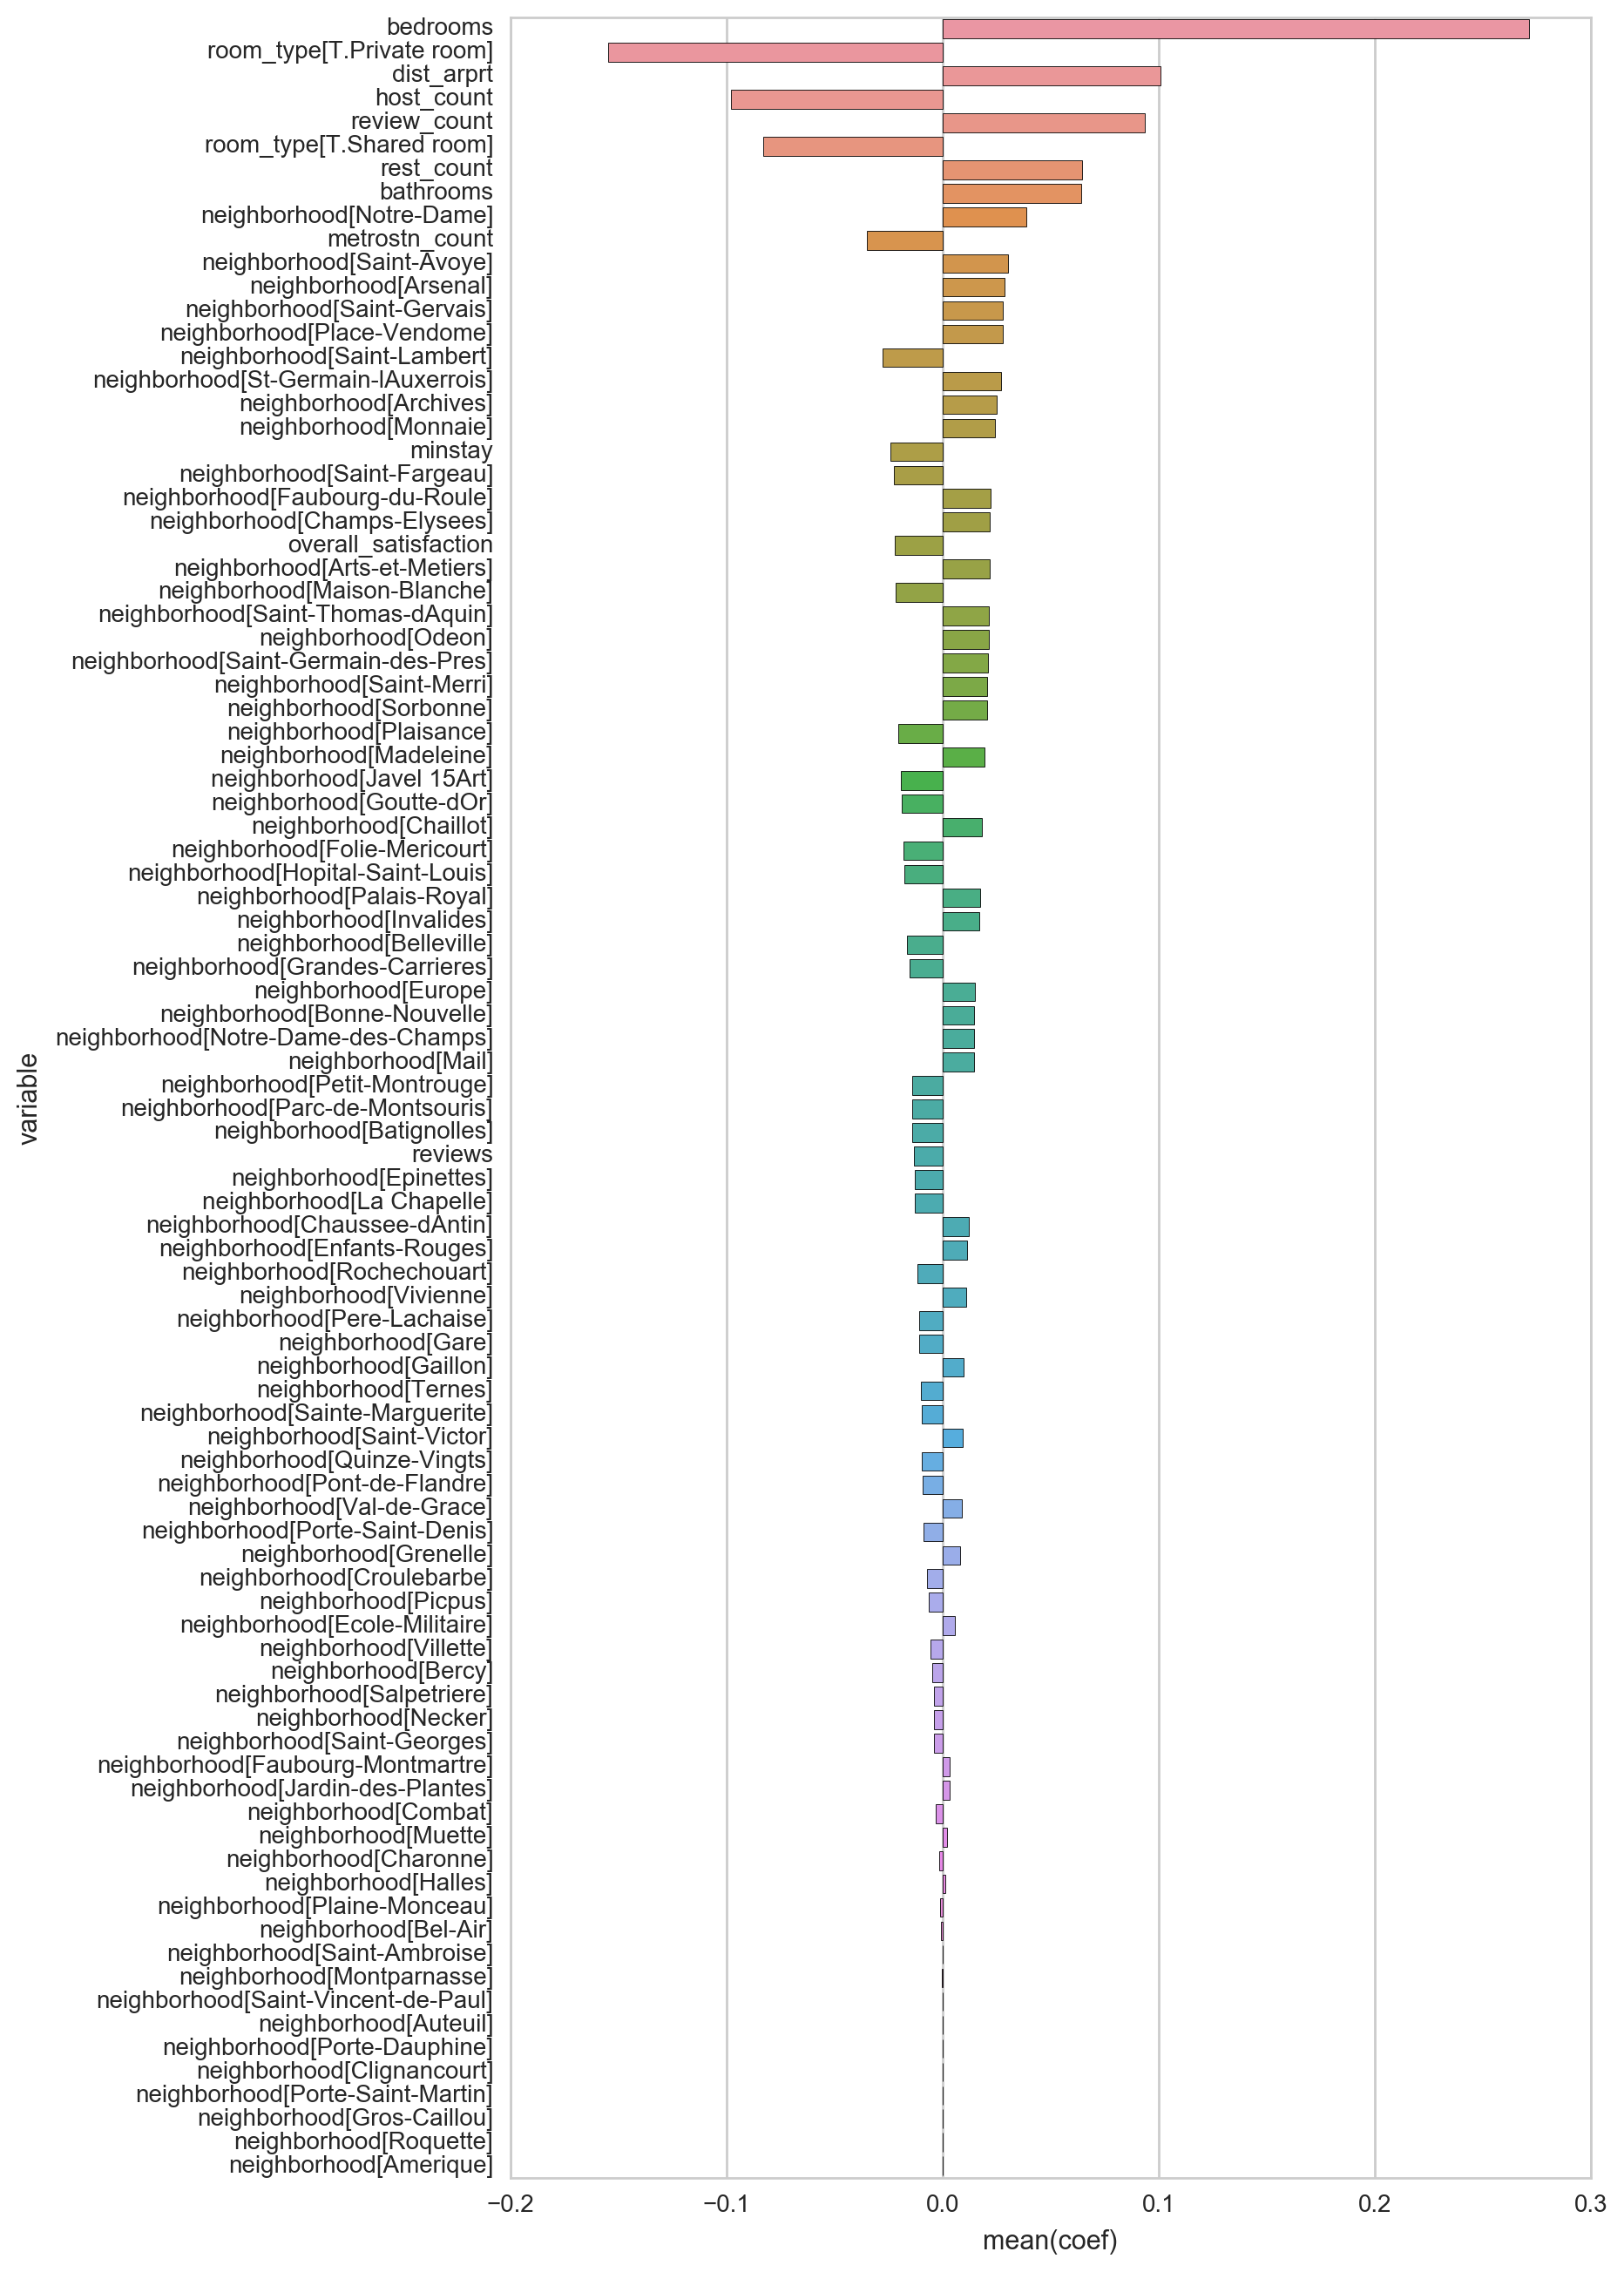

In [63]:
fig, ax = plt.subplots(figsize=(8,16))

sns.barplot(y = enet_coef.variable, x = enet_coef.coef, data=enet_coef)


In [64]:
enet_coef = enet_coef.reset_index(drop=True)

In [65]:
enet_coef

,abscoef,coef,variable
0,0.271363,0.271363,bedrooms
1,0.154700,-0.154700,room_type[T.Private room]
2,0.101156,0.101156,dist_arprt
3,0.097635,-0.097635,host_count
4,0.093825,0.093825,review_count
5,0.082979,-0.082979,room_type[T.Shared room]
6,0.064558,0.064558,rest_count
7,0.064307,0.064307,bathrooms
8,0.038775,0.038775,neighborhood[Notre-Dame]
9,0.034971,-0.034971,metrostn_count


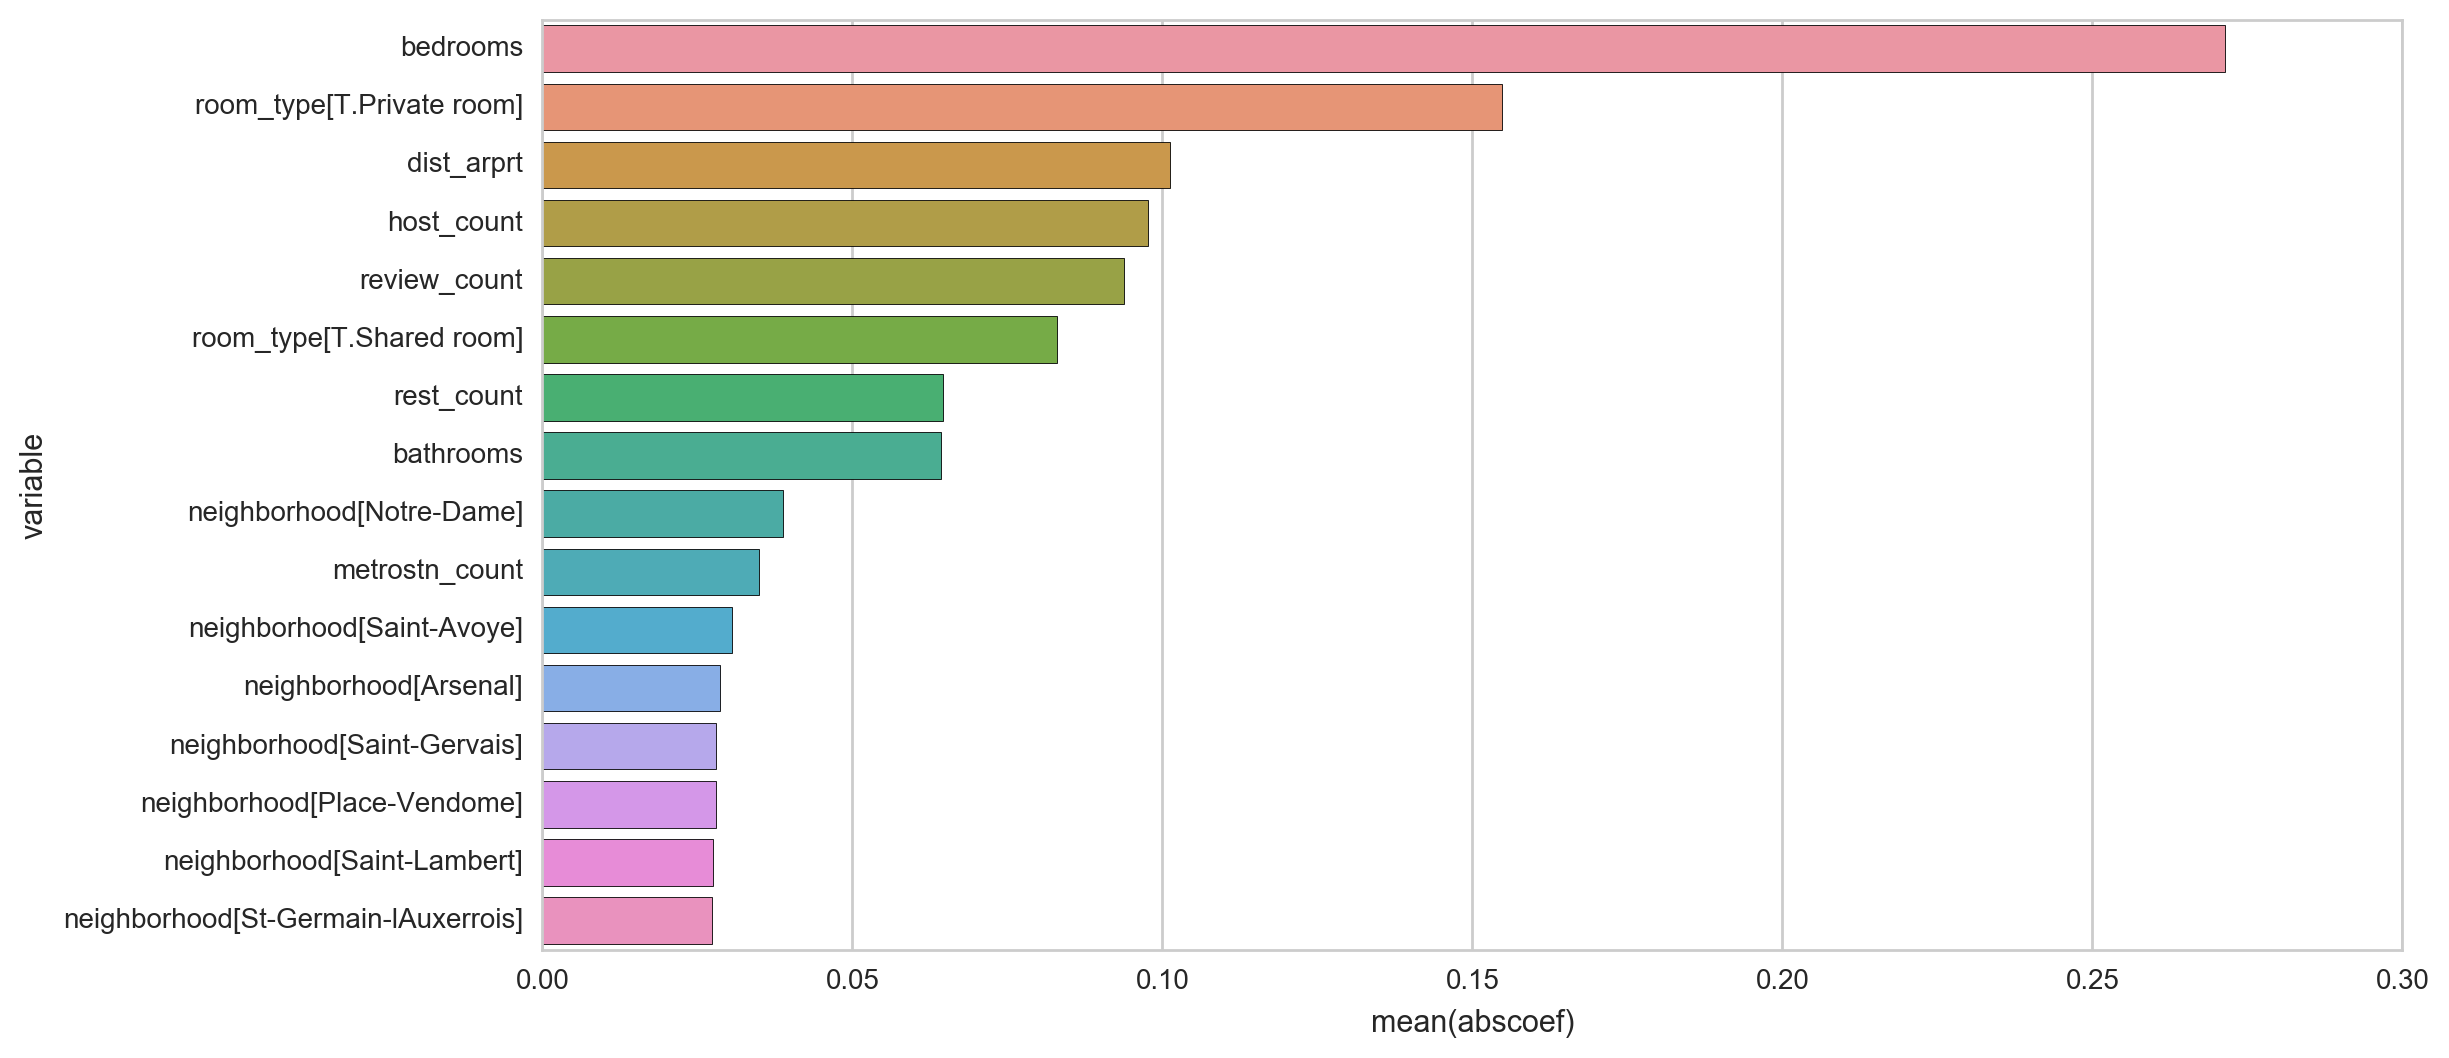

In [66]:
fig, ax = plt.subplots(figsize=(12,6))

sns.barplot(y = enet_coef.loc[0:15,:].variable, x = enet_coef.loc[0:15,:].abscoef, data=enet_coef.loc[0:15,:]
           )


In [46]:
tmp = X_train.reset_index(drop=True)
tmp = tmp.loc[np.abs(residuals) >= 2.5]
#tmp

In [47]:
#tmp.ix[7670,:]

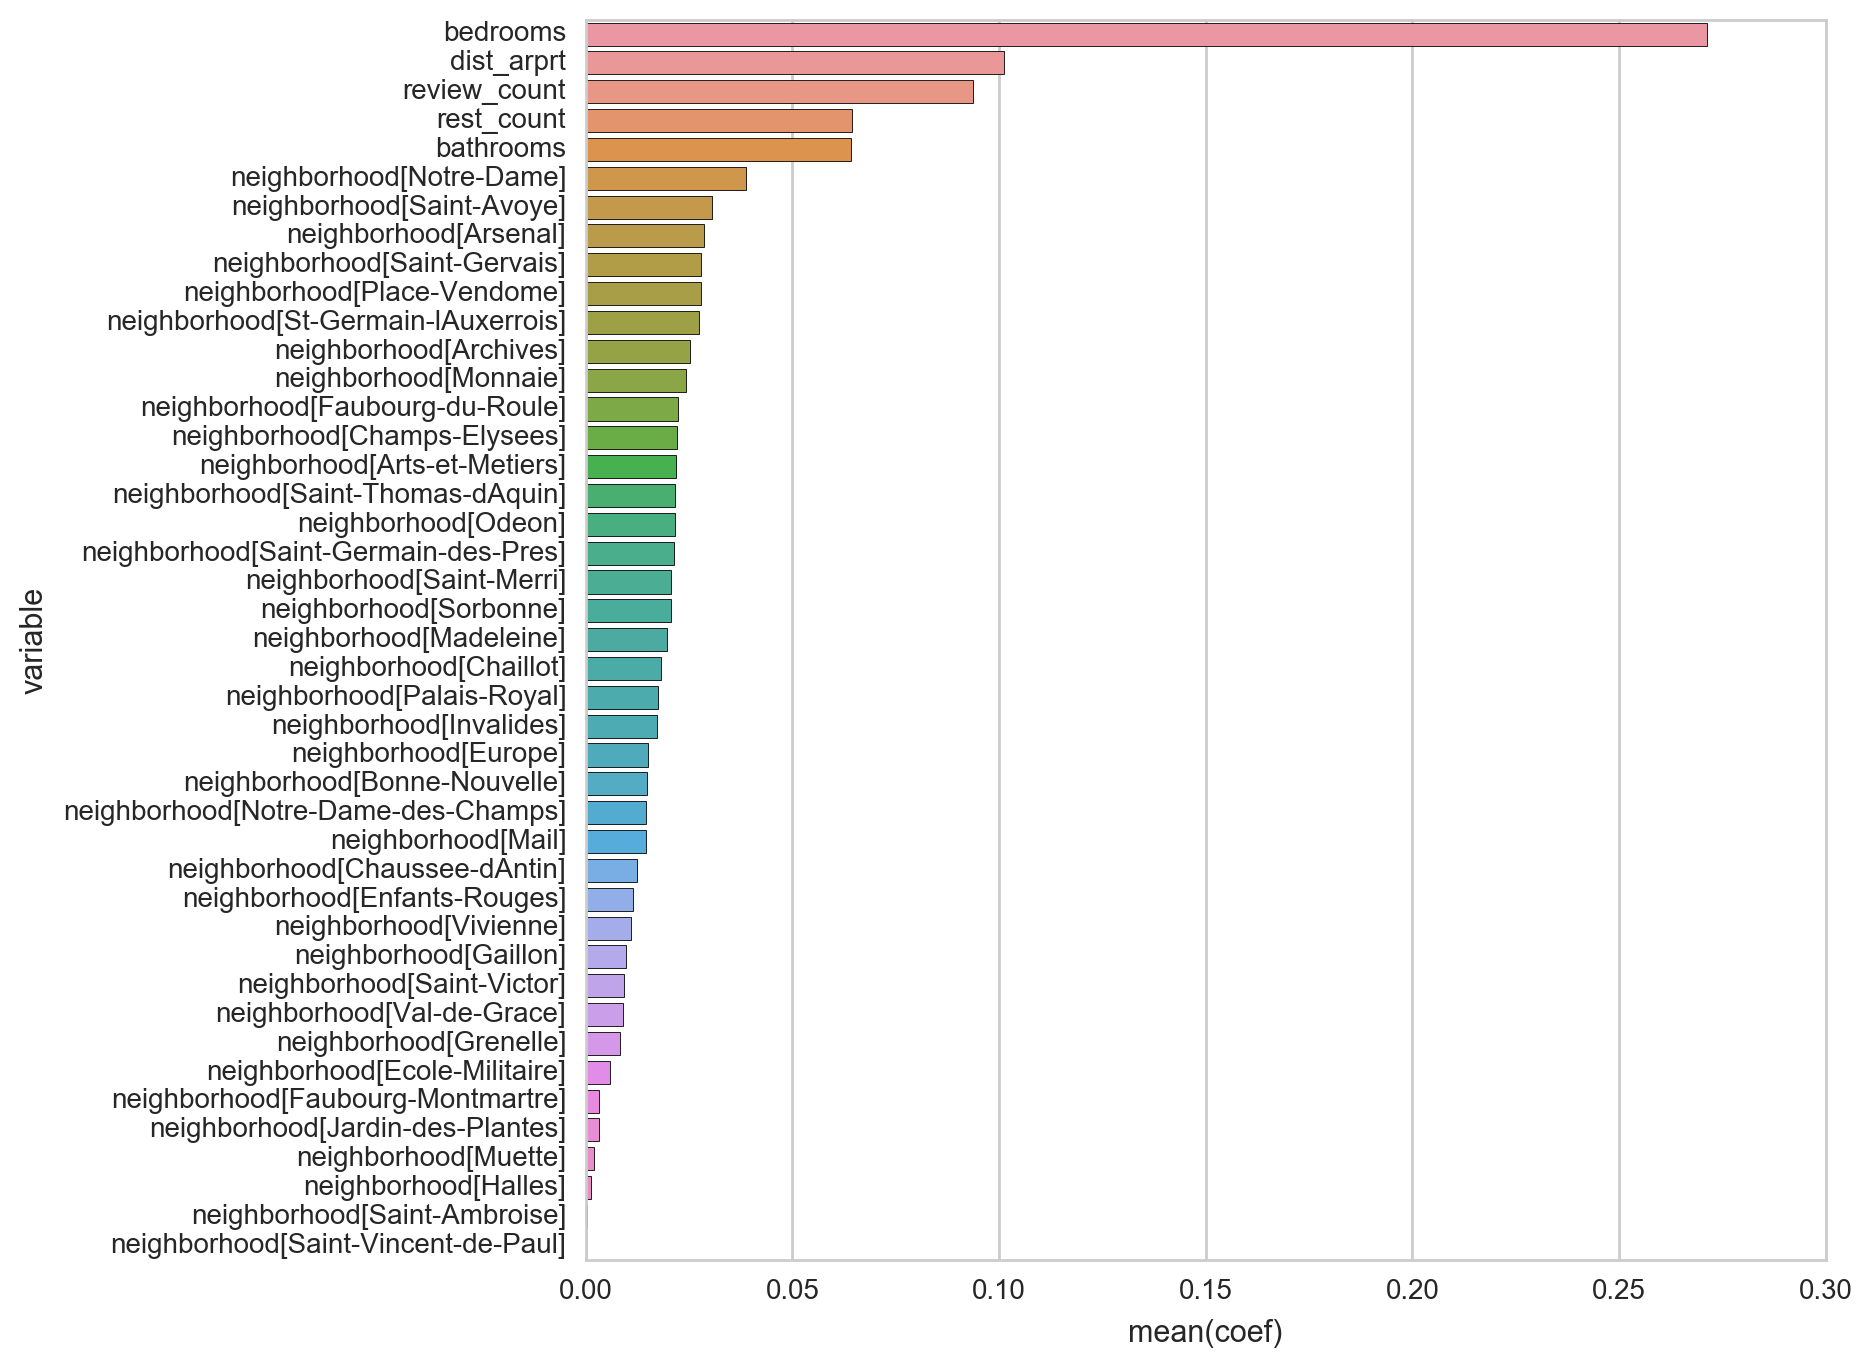

In [67]:
fig, ax = plt.subplots(figsize=(8,8))

sns.barplot(y = enet_coef[enet_coef.coef > 0].variable, x = enet_coef[enet_coef.coef > 0].coef, data=enet_coef,
            ax=ax
           )
plt.show()

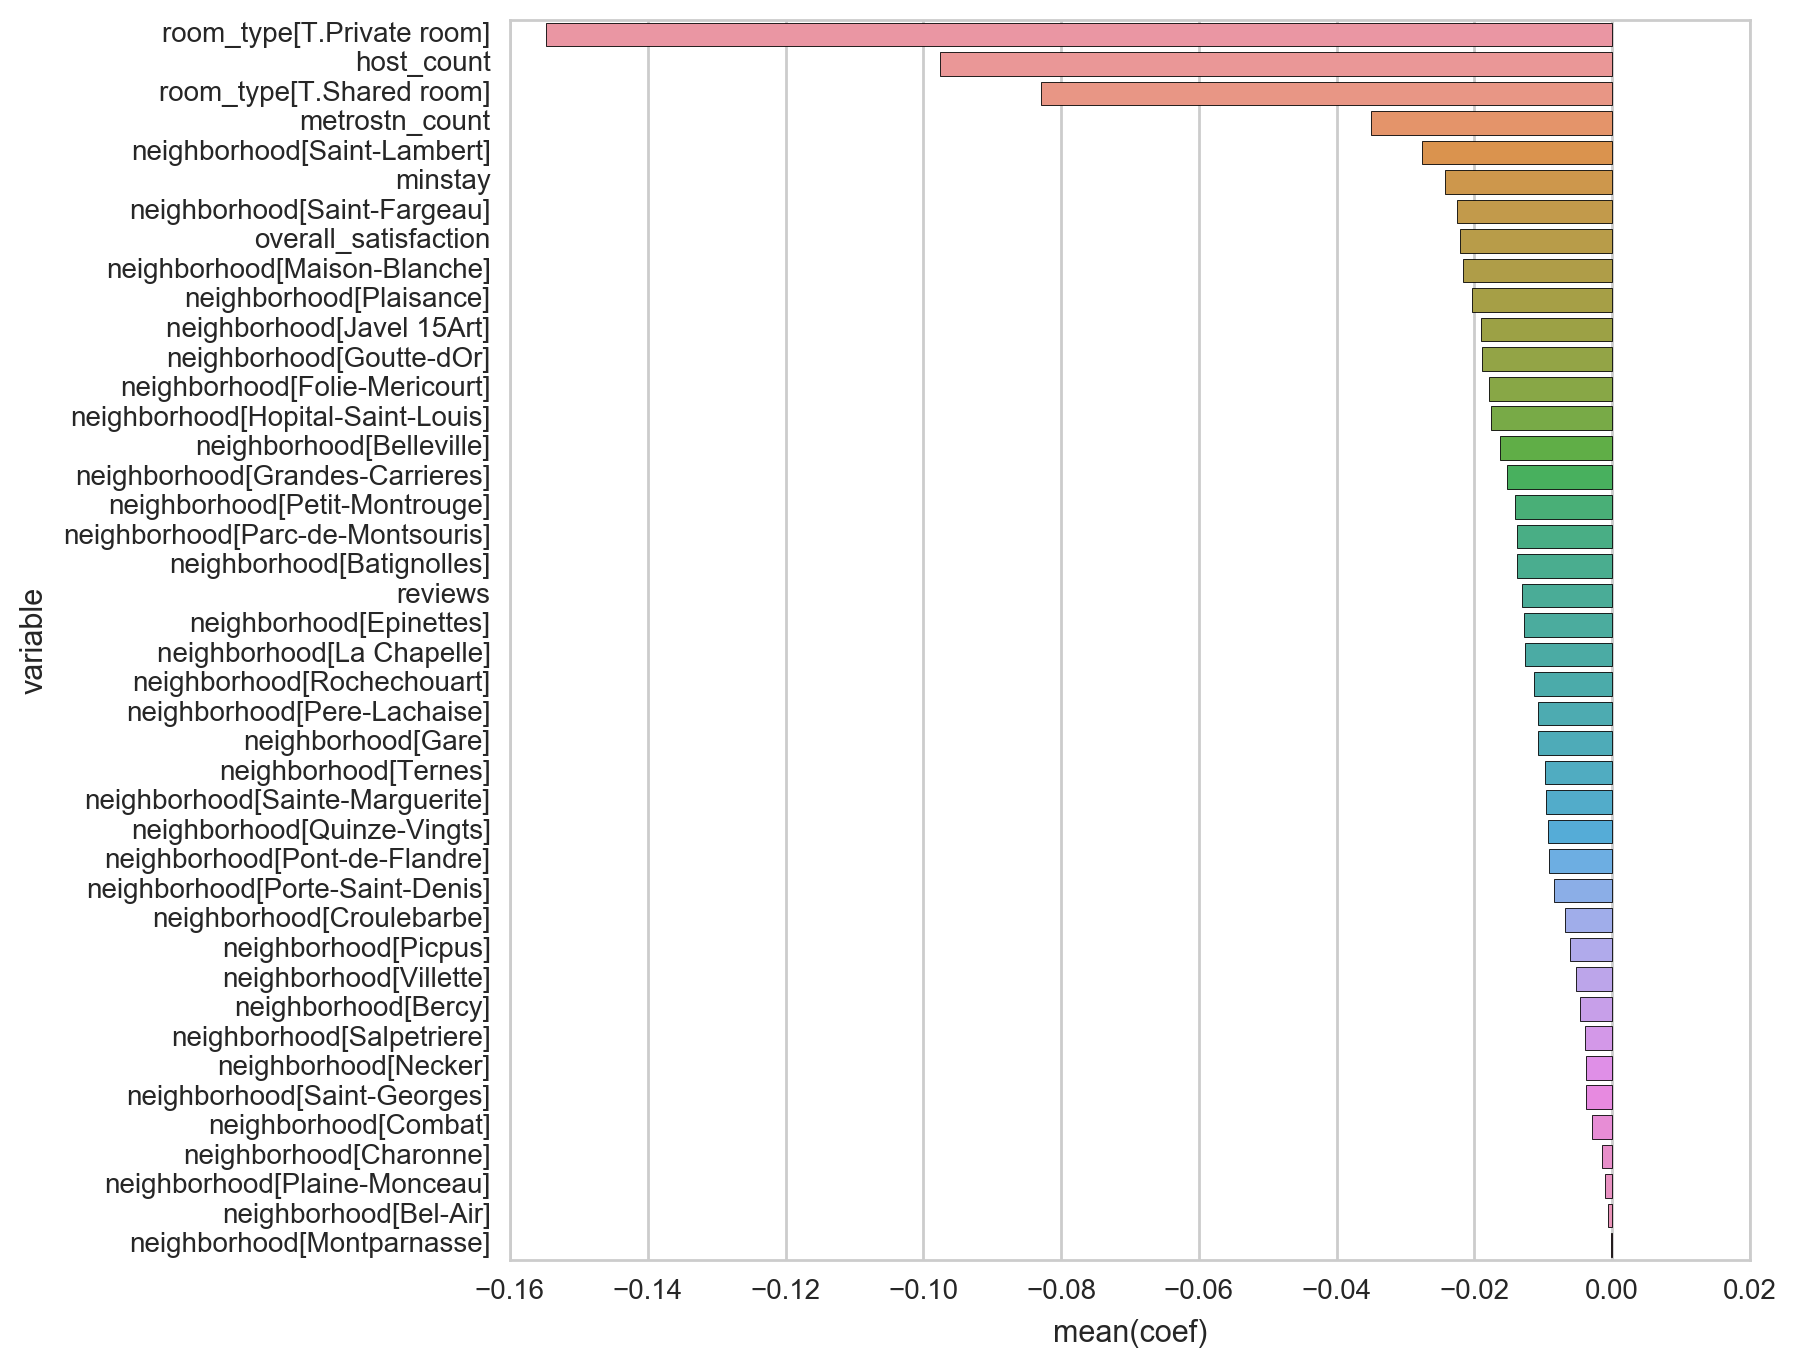

In [68]:
fig, ax = plt.subplots(figsize=(8,8))

sns.barplot(y = enet_coef[enet_coef.coef < 0].variable, x = enet_coef[enet_coef.coef < 0].coef, data=enet_coef,
            ax=ax
           )
plt.show()